## MNIST CLASSIFICATION

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X,y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

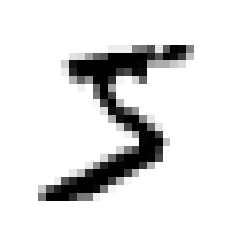

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np
y = y.astype(np.uint8)

In [6]:
# 훈련 세트는 이미 섞여있는 상태.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### 이진 분류 (숫자 5 True/False)

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=4)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=4, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

In [10]:
# 추가 교차 검증
# cross_val_score과 거의 동일하지만, 데이터 편향을 막기 위해 계층별로 교차검증
# 일반적으로 회귀는 cross_val_score, 분류는 stratifiedKFold를 많이 이용
# cross_val_score 내부적으로 stratifiedKFold를 사용하고 있음
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.96835
0.95135
0.9405


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9695, 0.9675, 0.9628])

In [12]:
# 더미 분류기 (5가 아닌 이미지)
# 무조건 아니라고 설정. (90% 확률로 정답)
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X,y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 오차 행렬

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred) # 행 - 실제 클래스, 열 - 예측 클래스

array([[53729,   850],
       [ 1154,  4267]])

In [16]:
confusion_matrix(y_train_5, y_train_5) # 완벽한 상태

array([[54579,     0],
       [    0,  5421]])

In [17]:
# 정밀도, 재현율
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8338870431893688

In [18]:
recall_score(y_train_5, y_train_pred)

0.7871241468363771

In [19]:
# f1_score: 정밀도와 재현율의 조화 평균
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8098310874928828

In [20]:
#정밀도와 재현율 두마리 토끼는 불가능. - 정밀도/재현율 트레이드오프
# 임곗값 탐색
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1570.91971558])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds =  precision_recall_curve(y_train_5, y_scores)

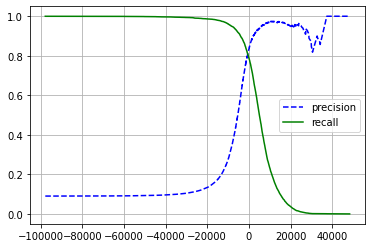

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision"),
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.grid(True)
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

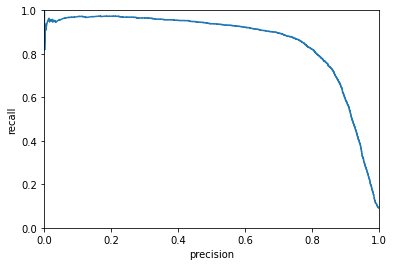

In [24]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("precision")
plt.ylabel("recall")
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [26]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000480538202787

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.6910164176351227

In [29]:
# 이진 분류에서 널리 사용하는 ROC 곡선
from sklearn.metrics import roc_curve 
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

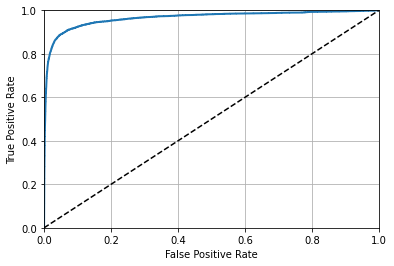

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.grid(True)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate") # 재현율과 같음
    
plot_roc_curve(fpr, tpr)
plt.show()

AUC (area under the curve)
- 완벽한 분류기의 AUC는 1에 가깝고,
- 완전한 랜덤 분류기의 AUC는 0.5다. (대각 직선)

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9652964469094635

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

In [33]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스만 사용
fpr_forest, tpr_forest, thresholds_forest, = roc_curve(y_train_5, y_scores_forest)

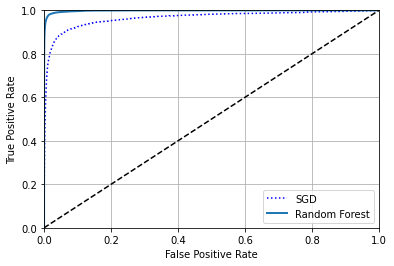

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest,tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 다중 분류
OvO, OvR
- 이진 분류기를 여러 개 사용해 다중 클래스를 분류할 수도 있음.
- 이진 분류기 사용 시 사이킷런에서 자동으로 OvR 또는 OvO 실행

In [36]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [37]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [38]:
np.argmax(some_digit_scores)

5

In [39]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [40]:
svm_clf.classes_[5]

5

In [41]:
# OvR 강제
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
len(ovr_clf.estimators_)

10

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89985, 0.89505, 0.90465])

### 에러분석


In [44]:
# 오차행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5587,    0,   23,    5,    9,   48,   36,    6,  208,    1],
       [   0, 6409,   38,   25,    4,   44,    4,    8,  199,   11],
       [  27,   27, 5248,   94,   72,   28,   66,   40,  346,   10],
       [  23,   18,  119, 5242,    2,  214,   27,   41,  374,   71],
       [  12,   14,   49,   10, 5209,   12,   36,   25,  309,  166],
       [  27,   16,   34,  171,   54, 4480,   78,   16,  486,   59],
       [  30,   16,   45,    2,   42,   98, 5559,    3,  122,    1],
       [  21,   11,   53,   29,   51,   13,    3, 5707,  171,  206],
       [  18,   65,   47,   89,    3,  127,   25,   10, 5422,   45],
       [  26,   19,   29,   65,  116,   39,    1,  181,  345, 5128]])

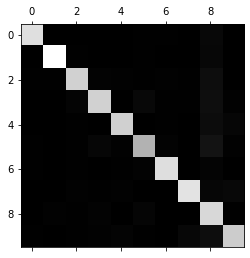

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

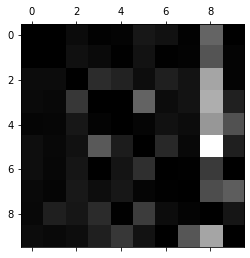

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [51]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

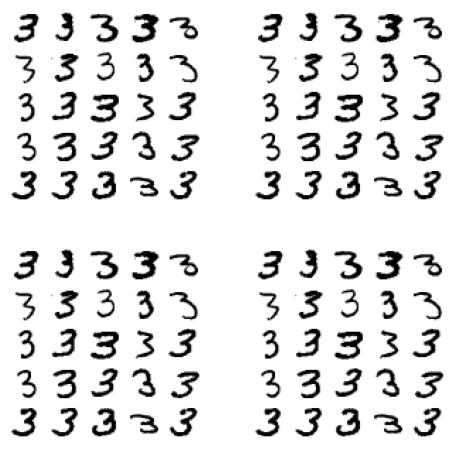

In [52]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)  # plot_digits - 단순히 matplotlib의 imshow() 함수를 사용하는 함수임
plt.subplot(222); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_aa[:25], images_per_row=5)
plt.show()

### 다중 레이블 분류

In [53]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [55]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [58]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### 다중 출력 분류

In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

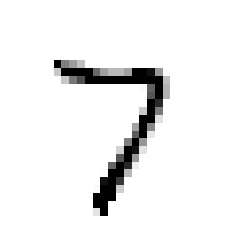

In [64]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digits(clean_digit)